In [2]:
from pyhht import *
from scipy.signal import argrelmax, argrelmin, resample
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

%matplotlib inline

In [3]:
trend = ts = np.linspace(0, 1, 10000)
mode1 = np.sin(2 * np.pi * 5 * ts)
mode2 = np.sin(2 * np.pi * 10 * ts)

## Decompose a signal into the IMFs

In [4]:
t = 2 * np.pi * ts
signal = np.cos(80 * t) + 0.8 * np.sin(50 * t) + \
    0.6 * np.sin(25 * t) + 0.4 * np.sin(10 * t) + 0.3 * np.cos(3 * t)
emd = EMD(signal)
imfs = emd.decompose()

## Check that the sum of the IMFs are close to the original signal

In [5]:
signal = np.sum([trend, mode1, mode2], axis=0)
emd = EMD(signal)
imfs = emd.decompose()
print(imfs.sum(0) - signal)

[  0.00000000e+00   5.20417043e-18  -4.51028104e-17 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


## Plot the IMF Functions

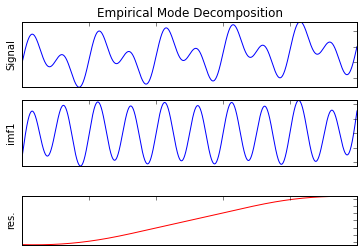

In [6]:
signal = np.sum([trend, mode1, mode2], axis=0)
decomposer = EMD(signal, t=ts)
imfs = decomposer.decompose()
plot_imfs(signal, imfs)

In [7]:
signal = np.sum([trend, mode1, mode2], axis=0)
decomposer = EMD(signal, t=ts)
imfs = decomposer.decompose()
n_imfs = imfs.shape[0]
n_maxima = argrelmax(imfs[n_imfs - 1, :])[0].shape[0]
n_minima = argrelmin(imfs[n_imfs - 1, :])[0].shape[0]

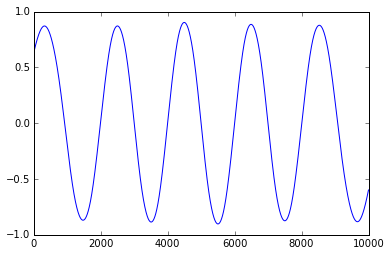

In [8]:
plt.plot(imfs[-2])

### DataFrame from CSV file Containing the Data

In [9]:
data = []
with open('EURUSD.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        data.append(row)

EURUSD = pd.DataFrame(data)    

In [10]:
EURUSD = EURUSD[['Date', 'Open', 'High', 'Low', 'Price']]
EURUSD.tail()

,Date,Open,High,Low,Price
4994,10-Mar-88,1.2427,1.2434,1.2375,1.2427
4995,9-Mar-88,1.2402,1.2447,1.2382,1.2402
4996,8-Mar-88,1.2428,1.2444,1.2322,1.2428
4997,7-Mar-88,1.2351,1.2369,1.2209,1.2351
4998,4-Mar-88,1.2231,1.2239,1.2172,1.2231


### Apply EMD to the EURUSD Data

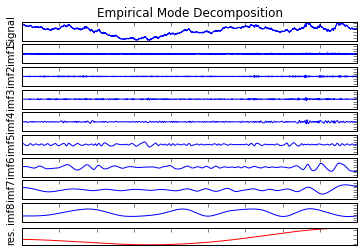

In [11]:
ts = np.array(EURUSD.index)
data = EURUSD['Price']

signal_full = np.array([float(d) for d in data])
signal = signal_full[:int(0.9*len(signal_full))]

decomposer = EMD(signal, t=ts[:int(0.9*len(signal_full))])
imfs = decomposer.decompose()

plt.figure(figsize=(12,8))
plot_imfs(signal, imfs)

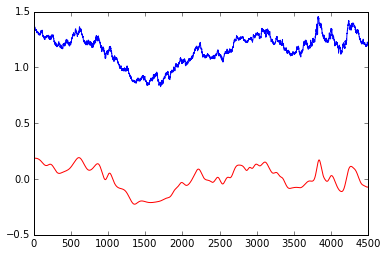

In [12]:
plt.plot(signal)
trend = imfs[8]+imfs[7]+imfs[6]+imfs[5]
plt.plot(trend, 'r-')

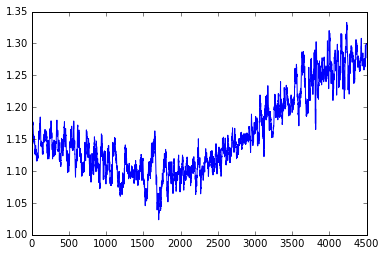

In [13]:
resid = signal - trend
plt.plot(resid)

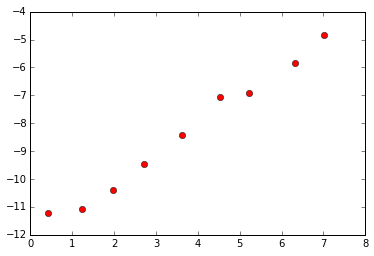

In [14]:
period = []
energy = []
for imf in imfs:
    p = len(imf)/(np.sum(np.abs(np.diff(np.sign(imf))))/2.)
    e = np.mean(np.abs(imf)**2)
    period.append(np.log(p))
    energy.append(np.log(e))

plt.plot(period, energy, 'ro')

## Energy-Ratio Selection

7


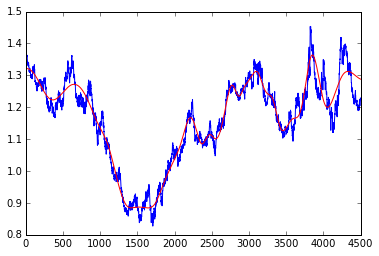

In [15]:
energy = []
for f in imfs[:-1]:
    energy.append(sum(np.abs(f)**2))
E_selected_modes = [i+1 for i, x in enumerate(zip(energy[:-1], energy[1:])) if x[1]>x[0]]

zero_crossings = []
for f in imfs[:-1]:
    zero_crossings.append(sum(np.abs(np.diff(np.sign(f)))/2))
R = [x/y for x, y in zip(zero_crossings[:-1], zero_crossings[1:])]
t_u = 2.645
t_l = 1.83
R_selected_modes = [i+1 for i,r in enumerate(R) if r>=t_u or r<=t_l]

i_star = min(set(R_selected_modes) or set(E_selected_modes))

trend = imfs[i_star-1] if i_star >2 else np.zeros(len(imfs[0]))

for i in range(i_star,len(imfs)):
    trend += imfs[i]

print(i_star)
plt.plot(signal)
plt.plot(trend, 'r-')

## testing residuals

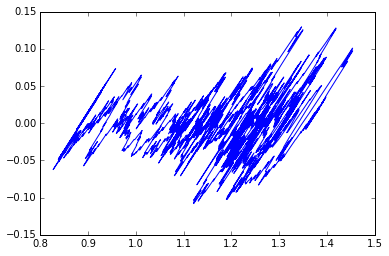

In [16]:
resid = signal - trend
plt.plot(signal, resid)

## Covariance Matrix of the IMFs

In [17]:
decomp = np.cov(imfs)/np.var(signal)
print("Verifying that the sum of all decompositions should be ~1: %s" % np.sum(decomp))
print("Sum of individual IMF contribtions - %s" % np.trace(decomp))
print("Sum of contributions of all he interactions - %s" % (np.sum(decomp) - np.trace(decomp)))

print("Contribution due to the residual - %s" % decomp[-1][-1])

print(np.var(trend)/np.var(signal), np.var(resid)/np.var(signal))

Verifying that the sum of all decompositions should be ~1: 3.67610320868
Sum of individual IMF contribtions - 1.80112404821
Sum of contributions of all he interactions - 1.87497916047
Contribution due to the residual - 0.199038838231
0.963995686088 0.0651678308491


## Hilbert Transform

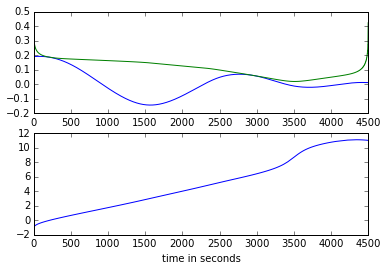

In [18]:
from scipy.signal import hilbert

t_signal = imfs[-2]
analytic_signal = hilbert(t_signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
fs = float(len(t_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs

fig = plt.figure()
t = range(len(t_signal))
ax0 = fig.add_subplot(211)
ax0.plot(t, t_signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")

ax1 = fig.add_subplot(212)
ax1.plot(t, instantaneous_phase)
ax1.set_xlabel("time in seconds")

nan


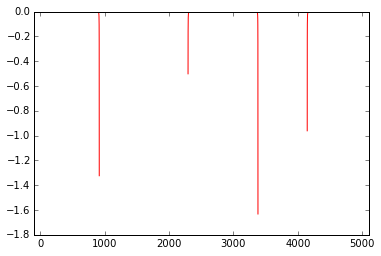

In [19]:
amp_stat = np.diff(np.log(t_signal))
print(amp_stat.mean())
plt.figure()
plt.plot(np.diff(amp_stat), 'r-')
plt.xlim(-100,5100)

import scipy.stats as stats
# plt.figure()
# stats.probplot(np.diff(amp_stat), dist="norm",plot=plt)

In [20]:
def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast windowa
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 2   # number of previous observations to use
h = 1   # forecast horizon
X,y = organize_data(amp_stat, k, h)
print(X.shape)
print(y.shape)

(4496, 2)
(4496,)


2 15
0.00571657999983 -0.740987755642


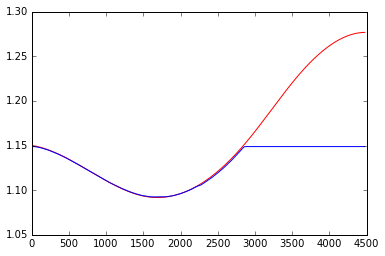

In [21]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def embedding_reconstruction(signal_arr, delay, dim):
    d = dim - 1
    tau = delay
    rolling_win = tau * d + 1
    
    sample = np.array([x[::tau] for x in rolling_window(signal_arr,rolling_win)])
    return sample

def make_sym_dist_matrix(arr_of_points):
    from scipy.spatial.distance import pdist
    vals = pdist(arr_of_points, 'euclidean')
    n = len(arr_of_points)
    m = np.zeros([n,n], dtype=np.double)
    xs,ys = np.triu_indices(n,k=1)
    m[xs,ys] = vals
    m[ys,xs] = vals
    m[np.diag_indices(n)] = 0
    return m

def calculate_optimal_embedding(X, clf_to_use,  start_dim=5, start_delay=5):
    not_converged = True

    delay = start_delay
    dim = start_dim

    error_dict = dict()
    n_train = 0

    def calculate_fit_error(X, delay, dim, clf):
        if (delay,dim) in error_dict:
            return error_dict[(delay,dim)]
        else:
            # n_train += 1
            # print(" Training number: %s" % n_train)
            if delay < 1 or dim < 2:
                error_dict[(delay,dim)] = 999999999.
            else:
                training_results = train_model(X, delay, dim, clf)
                error_dict[(delay,dim)] = training_results['mse']
                # print(error_dict)
            return error_dict[(delay, dim)]
    
    n_iter = 0
    min_delay = 1
    min_dim = 2
    while not_converged:
        prev_delay = delay
        prev_dim = dim
        n_iter += 1
        # print(" Iteration number: %s" % n_iter)
        # print("    Current Params: %s, %s" % (delay, dim))
        index_dict = dict()
        for i in range(3):
            for j in range(3):
                score= calculate_fit_error(X, delay+i-1, dim+j-1, clf_to_use)
                index_dict[score] = (i-1, j-1)
        min_val= min(index_dict.keys())
        d_delay, d_dim = index_dict[min_val]

        dim += d_dim
        delay += d_delay

        if prev_delay == delay and prev_dim == dim:
            not_converged = False
            break

        if delay == 1 and dim ==1:
            not_converged = False
            break
    return delay, dim

from sklearn import ensemble
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

embedding_params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2,
                    'learning_rate': 0.01, 'loss': 'ls'}
train_params = {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 2,
                    'learning_rate': 0.01, 'loss': 'ls'}
clf_embed = ensemble.GradientBoostingRegressor(**embedding_params)
clf_train = ensemble.GradientBoostingRegressor(**train_params)

def train_model(X, delay, dim, clf, train_frac=0.5):
    sample = embedding_reconstruction(X, delay=delay, dim=dim)
    
    train_vect = sample[:,0:dim-1]
    output_vect = sample[:,-1]
    
    sample_size = len(output_vect)
    train_size = int(sample_size*train_frac)

    train_X = train_vect[:train_size,]
    test_X = train_vect[train_size+1:,]

    train_Y = output_vect[:train_size]
    test_Y = output_vect[train_size+1:]
    
    clf.fit(train_X, train_Y)
    
    predict_Y = clf.predict(test_X)
    mse = mean_squared_error(test_Y, predict_Y)
    r2 = r2_score(test_Y, predict_Y)
    
    return {'model':clf, 'X':train_vect, 'Y': output_vect, 'predict_Y':clf.predict(train_vect) , 'mse':mse, 'r2':r2}


delay, dim =  calculate_optimal_embedding(imfs[-3], clf_embed)
print(delay, dim)
training_results = train_model(imfs[-1],7,4, clf_train, train_frac=0.50)
print(training_results['mse'],training_results['r2'])
plt.plot(training_results['Y'],'r-')
plt.plot(training_results['predict_Y'],'b-')

0.00954882179056 -1.90809921643


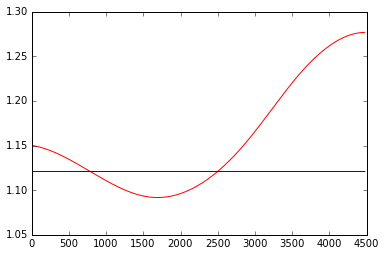

In [22]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid)

training_results = train_model(imfs[-1],7,4, grid, train_frac=0.50)
print(training_results['mse'],training_results['r2'])
plt.plot(training_results['Y'],'r-')
plt.plot(training_results['predict_Y'],'b-')

In [23]:
calculate_optimal_embedding(imfs[-4], clf_embed)

(1, 2)

1 0
2 4599


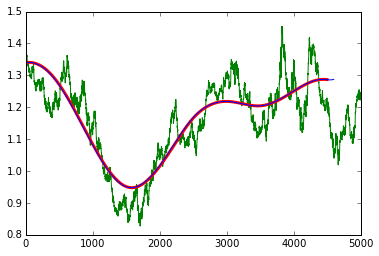

In [24]:
from sklearn.linear_model import LinearRegression


Y = imfs[-5]

def predict_imf(imf_arr, len_predict):
    regressor = LinearRegression(normalize=True)
    delay, dim =  calculate_optimal_embedding(imf_arr, regressor)
    predictors = embedding_reconstruction(imf_arr, delay, dim-1)

    training_results = train_model(imf_arr, delay, dim, regressor, train_frac=0.05)
    #print(training_results['mse'],training_results['r2'])
    
    y_predict = training_results['model'].predict(predictors)
    new_imf = np.append(imf_arr, y_predict[-delay:])
    while len(y_predict) - len(imf_arr) < 100:
        tmp = embedding_reconstruction(new_imf, delay,dim-1)
        y_predict = training_results['model'].predict(tmp)
        new_imf = np.append(new_imf, y_predict[-delay:])
        #print(new_imf)
    training_results['predict_Y'] = y_predict
    return training_results

trend = np.zeros(len(imfs[0]))
predict = []
for i in range(1, 3):
    trend += imfs[-i]
    training_results = predict_imf(imfs[-i],100)
    print(i, len(predict))
    if len(predict) == 0:
        predict = training_results['predict_Y']
    else:
        # print(training_results['predict_Y'])
        predict += training_results['predict_Y']

plt.plot(signal_full, 'g-')
plt.plot(trend,'r-',lw=3)
plt.plot(predict,'b-')

In [25]:
from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

train_size = int(len(amplitude_envelope)/2)
test_size = len(amplitude_envelope) - train_size

regressor = LinearRegression(normalize=True)
regressor.fit(X[:train_size], y[:train_size])

plt.plot(y, label='True demand', color='green', linewidth=1)
plt.plot(regressor.predict(X), 
     '--', color='#EB3737', linewidth=1, label='Prediction')
plt.plot(y[:train_size], label='Train data', color='#3700B8', linewidth=1)
# plt.xticks(arange(len(dates))[1::4],dates[1::4], rotation=45)
plt.legend(loc='upper right')
# ylabel('beer consumed (millions of litres)')
# show()

NameError: name 'matplotlib' is not defined

## Comparing the smoothing behaviour of 2 or more different windows

In [ ]:
ts = np.array(EURUSD.index)
data = EURUSD['Price']

signal = np.array([float(d) for d in data])
small_length = 2100
signal_small = signal[:small_length]

decomposer = EMD(signal, t=ts)
imfs = decomposer.decompose()

decomposer_small = EMD(signal_small, t=ts[:small_length])
imfs_small = decomposer_small.decompose()

# plot_imfs(signal, imfs)
# plt.plot(signal)
# plt.plot(signal[:4100],'r-')

plt.plot(signal,'c+',alpha=0.3)
plt.plot(imfs[-1]+imfs[-2]+imfs[-3]+imfs[-4], 'r-')
plt.plot(imfs_small[-1]+imfs_small[-2]+imfs_small[-3], 'b-', lw=2)

In [ ]:
d = dict()
d[1] = 20
d[2] = 4
d[3] = 20
d[4] = 73
d[5] = 117

In [ ]:
avg_rating = sum([d[k]*k for k in d])/sum(d.values())

In [ ]:
scen1 = [0.2 , 0.2, 0.2 , 0.2 ,0.2]
scen2 = [0.96, 0.01, 0.01, 0.01, 0.01]
scen3 = [0.01, 0.96, 0.01, 0.01, 0.01]
scen4 = [0.01, 0.01, 0.96, 0.01, 0.01]
scen5 = prob
p5 = 0.5
scen6 = [(1-p5)/4, (1-p5)/4, (1-p5)/4, (1-p5)/4, p5]

In [ ]:
pobs_scen1 = np.cumprod([scen1[k-1]**d[k] for k in d])[-1]
pobs_scen2 = np.cumprod([scen2[k-1]**d[k] for k in d])[-1]
pobs_scen3 = np.cumprod([scen3[k-1]**d[k] for k in d])[-1]
pobs_scen4 = np.cumprod([scen4[k-1]**d[k] for k in d])[-1]
pobs_scen5 = np.cumprod([scen5[k-1]**d[k] for k in d])[-1]
pobs_scen6 = np.cumprod([scen6[k-1]**d[k] for k in d])[-1]

In [ ]:
norm = np.average([pobs_scen1, pobs_scen2, pobs_scen3, pobs_scen4, pobs_scen5, pobs_scen6])
p_scen1 = pobs_scen1 / norm * 1/6
p_scen2 = pobs_scen2 / norm * 1/6
p_scen3 = pobs_scen3 / norm * 1/6
p_scen4 = pobs_scen4 / norm * 1/6
p_scen5 = pobs_scen5 / norm * 1/6
p_scen6 = pobs_scen6 / norm * 1/6
[p_scen1, p_scen2, p_scen3, p_scen4, p_scen5, p_scen6]

In [ ]:
prob = [d[k] /sum(d.values()) for k in d]

In [ ]:
prob

In [ ]:
np.diff([-1,-1,1,1,-1,1])

In [ ]:
np.zeros(10)

In [ ]:
np.arange(25)

In [ ]:
np.append([1,2,3],[4,5,6])